In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install transforms3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for transforms3d: filename=transforms3d-0.4.1-py3-none-any.whl size=1376772 sha256=4779ca0b519a55195085222d355709e956546081bdcd4dbc09fcbaec1edd5318
  Stored in directory: /root/.cache/pip/wheels/7b/f0/88/0198ac6eca77ffa36e7247595585e9ec34e1dcc327847ebe73
Successfully built transforms3d


In [146]:
import matplotlib.pyplot as plt
import numpy as np
# import jax
# import jax.numpy as jnp
# from jax.config import config; config.update("jax_enable_x64", True)
# import transforms3d
from datetime import datetime
from tqdm import tqdm

In [6]:
!ls 'trainset'

cam
imu
vicon


In [209]:
import pickle
import sys
import time 

def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # need for python 3
  return d

dataset="11"
cfile = "./trainset/cam/cam" + dataset + ".p"
ifile = "./trainset/imu/imuRaw" + dataset + ".p"
# vfile = "./trainset/vicon/viconRot" + dataset + ".p"
cfile = "./testset/cam/cam" + dataset + ".p"
ifile = "./testset/imu/imuRaw" + dataset + ".p"

ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
# vicd = read_data(vfile)
toc(ts,"Data import")

Data import took: 0.38770127296447754 sec.



(240, 320, 3, 161)

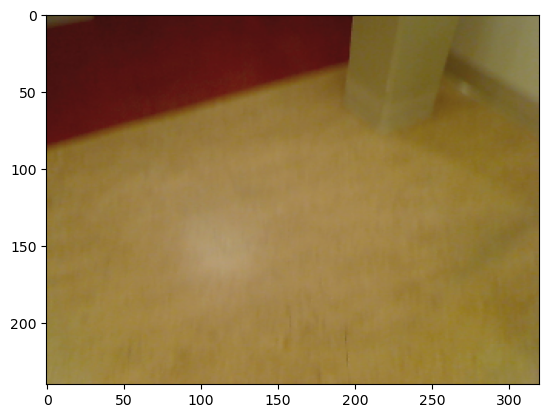

In [210]:
plt.imshow(camd['cam'][:, :, :, 100])
camd['cam'].shape

In [5]:
print('camd', camd['cam'].shape, camd['ts'].shape)
print('imud', imud['vals'].shape, imud['ts'].shape)
print('vicd', vicd['rots'].shape, vicd['ts'].shape)
imud['vals'] = imud['vals'].astype('float64')

camd (240, 320, 3, 1685) (1, 1685)
imud (6, 5645) (1, 5645)
vicd (3, 3, 5561) (1, 5561)


First, the IMU is calibrated by finding the inital value when there is no rotation. When there is no rotation, the rotation matrix (ground truth obtained from VICON data) is Identity.
As there is some noise in the VICON data, we consider a threshold value, to check for identity of the rotation matrices.
After obtaining the extent to which the matrices are identity, we consider that there was no motion till that reading, and after that the apparatus was moved.

We can use all readings till this point to estimate the bias.

In [ ]:
# Take an average of all values till a particular index
def calculate_bias(end_index: int, data_row) -> int:
  return jnp.average(data_row[:, :end_index], axis=1)

# find all data upto a particular threshold
def check_threshold(threshold: float, vicon_data) -> int:
  threshold_matrix = jnp.ones((3, 3))*threshold
  index: int = 0
  difference_calc = jnp.abs(np.eye(3)[:,:, jnp.newaxis]-vicd['rots'])
  thres_operation = threshold_matrix[:,:, jnp.newaxis] >= difference_calc

  for i in range(thres_operation.shape[2]):
    if not jnp.all(thres_operation[:,:,i]):break
    index += 1
  return index

# remove bias from data by subtracting that number
def remove_bias(biases, data):
  return data - biases[:, jnp.newaxis]

def scale_factor(Vref, bit_count, sensitivity_in_rad):
  return (Vref/(2**bit_count))/sensitivity_in_rad

def IMU_value(value, bias, sensitivity, Vref, bit_count):
  return (value-bias[:, jnp.newaxis]) * scale_factor(Vref, bit_count, sensitivity)

In [ ]:
threshold = 0.017
threshold_index = check_threshold(threshold, vicd['rots'])
# threshold_index = 700
print('Setting threshold as {} for identity rotation matrix, we get cut off index at {}'.format(threshold, threshold_index))
imu_biases = calculate_bias(threshold_index+1, imud['vals'])
imud_new = imud.copy()

Vref_acc = 3*1000 # in mV
Vref_gyro = 3*1000  # in mV (not same as the sheet)
sensitivity_acc = 300
sensitivity_gyro = 3.33*180/jnp.pi
scale_factor_gyro = scale_factor(Vref_gyro, 10, sensitivity_gyro)
scale_factor_acc = scale_factor(Vref_acc, 10, sensitivity_acc)
# g = 9.81
g = 1

A_corrected = IMU_value(imud_new['vals'][0:3, :], imu_biases[:3], sensitivity_acc, Vref_acc, 10)
# make separate for roll, pitch, yaw
W_corrected = IMU_value(imud_new['vals'][3:, :], imu_biases[3:], sensitivity_gyro, Vref_gyro, 10)

A_corrected = jnp.multiply(A_corrected * g, jnp.array([-1, -1, 1])[:, jnp.newaxis]) + jnp.array([0, 0, g])[:, jnp.newaxis]
Ax, Ay, Az = A_corrected
Wz, Wx, Wy = W_corrected

Setting threshold as 0.017 for identity rotation matrix, we get cut off index at 608


In [ ]:
# multiplication of 2 quaternions
@jax.jit
def quat_multi(q, p):
  qs, ps, qv, pv  = q[0], p[0], q[1:], p[1:]
  return jnp.hstack(((qs*ps) - jnp.dot(qv.T, pv), (qs*pv) + (ps*qv) + jnp.cross(qv, pv)))

@jax.jit
def quat_exp(q):
  qs, qv = q[0], q[1:]
  return jnp.exp(qs)*jnp.hstack((jnp.cos(jnp.linalg.norm(qv)), qv*jnp.sin(jnp.linalg.norm(qv))/jnp.linalg.norm(qv)))

@jax.jit
def quat_exp_v(q):
  qs=q[0, :]
  qv=q[1:,:]
    #qv=jnp.ones([5645,4])
  return jnp.exp(qs)*jnp.vstack((jnp.cos(jnp.linalg.norm(qv,axis=0)),(qv/jnp.linalg.norm(qv,axis=0))*jnp.sin(jnp.linalg.norm(qv,axis=0))))
    # print(res)
  # qs, qv = q[0], q[1:]
  # return jnp.exp(qs)*jnp.vstack((jnp.cos(jnp.linalg.norm(qv, axis=0)), (qv/jnp.linalg.norm(qv, axis=0))*jnp.sin(jnp.linalg.norm(qv, axis=0))))

# calculating next quaternion
@jax.jit
def calculate_q(q, w, t):
  p = quat_exp(jnp.hstack((0, t*w/2)))
  q = quat_multi(q, p)
  return q

def calculate_q_v(q):
  return quat_multi(q[:4], q[4:])

def rotation_matrix(z, y, x):
  Z = jnp.array([[jnp.cos(z), -jnp.sin(z), 0], [jnp.sin(z), jnp.cos(z), 0], [0, 0, 1]])
  Y = jnp.array([[jnp.cos(y), 0, jnp.sin(y)], [0, 1, 0], [-jnp.sin(y), 0, jnp.cos(y)]])
  X = jnp.array([[1, 0, 0], [0, jnp.cos(x), -jnp.sin(x)], [0, jnp.sin(x), jnp.cos(x)]])
  return jnp.dot(jnp.dot(Z, Y), X)

In [ ]:
W = jnp.vstack((Wx, Wy, Wz))
Q = jnp.zeros((4, W.shape[1]), dtype=jnp.float64)
Q = Q.at[0, 0].set(1)
T = imud_new['ts'][0][1:] - imud_new['ts'][0][:-1]
Exp = quat_exp_v(jnp.vstack((jnp.zeros(W.shape[1]-1), T*W[:,:-1]/2)))
# np.apply_along_axis(calculate_q_v, 0, np.vstack((Q[:,:-1], Exp)))
for i in range(W.shape[1]-1):
  Q = Q.at[:, i+1].set(quat_multi(Q[:, i], Exp[:, i]))

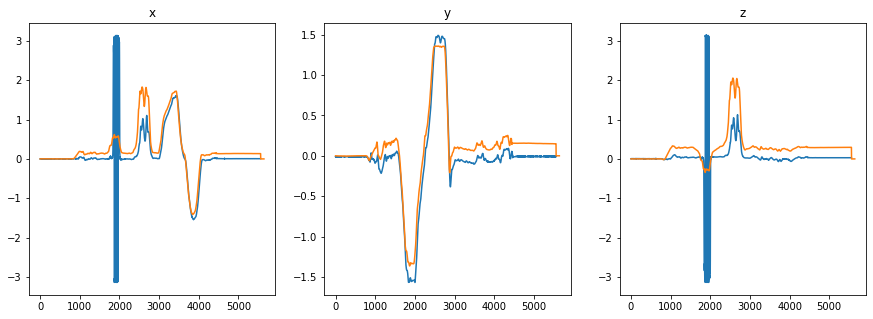

In [ ]:
V = jnp.zeros((3, vicd['rots'].shape[2]))
Q_to_V = jnp.zeros((3, Q.shape[1]))
for v in range(vicd['rots'].shape[2]):
  V = V.at[:, v].set(jnp.array(transforms3d.euler.mat2euler(vicd['rots'][:,:,v])))
  Q_to_V = Q_to_V.at[:, v].set(jnp.array(transforms3d.euler.quat2euler(Q[:,v])))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['x', 'y', 'z']
for i in range(3):
  axes[i].set_title(titles[i])
  axes[i].plot(V[i,:])
  axes[i].plot(Q_to_V[i,:])
plt.show()

Calculations for acceleration

In [ ]:
@jax.jit
def quat_inverse_v(q):
  return (q*jnp.array([1., -1., -1., -1.])[:, np.newaxis])/(jnp.linalg.norm(q, axis=0)**2)

@jax.jit
def quat_inverse(q):
  return q*jnp.array([1., -1., -1., -1.])/(jnp.linalg.norm(q)**2)

@jax.jit
def quat_multi_v(q, p):
  qs, ps, qv, pv  = q[0, :], p[0, :], q[1:, :], p[1:, :]
  return jnp.vstack(((qs * ps) - jnp.sum(qv * pv, axis=0), (qs * pv) + (ps * qv) + jnp.cross(qv, pv, axis=0)))

@jax.jit
def calculate_a(q):
  return quat_multi_v(quat_inverse_v(q), quat_multi_v(zero_g[:, jnp.newaxis], q))

zero_g = jnp.array([0., 0., 0., g])
A = jnp.zeros((4, Q.shape[1]))
# for i, q in enumerate(Q.T):
  # A = A.at[:, i].set(calculate_a(q))
A = A.at[:, :].set(calculate_a(Q))

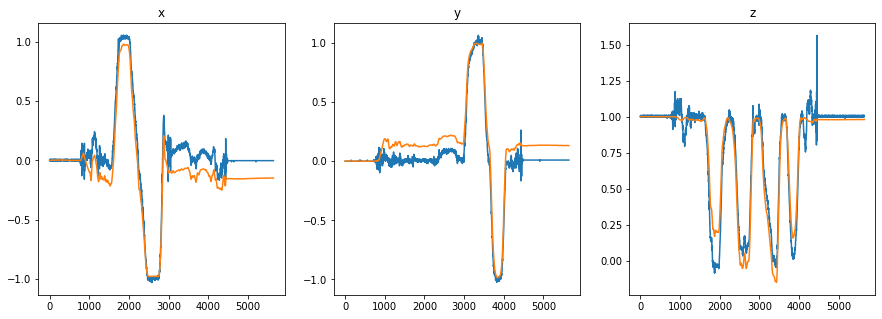

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['x', 'y', 'z']
for i in range(3):
  axes[i].set_title(titles[i])
  axes[i].plot(A_corrected[i])
  axes[i].plot(A[i+1,:])
plt.show()

In [ ]:
perturb = 0.001
S1_loss, S2_loss = [], []
@jax.jit
def quat_log(q):
  qs, qv = q[0], q[1:]+perturb
  return jnp.hstack((jnp.log(jnp.linalg.norm(q+perturb)), (qv/jnp.linalg.norm(qv))*jnp.arccos(qs/jnp.linalg.norm(q+perturb))))

@jax.jit
def quat_log_v(q):
  qs, qv = q[0, :], q[1:, :]
  return jnp.vstack((jnp.log(jnp.linalg.norm(q, axis=0)), (qv/jnp.linalg.norm(qv, axis=0))*jnp.arccos(qs/jnp.linalg.norm(q, axis=0))))


def cost_fun(q):
  s1, s2 = 0, 0
  s1 = 0.5 * jnp.power(jnp.linalg.norm(2 * quat_log_v(quat_multi_v(quat_inverse_v(q[:, 1:]), quat_multi_v(q, Exp)[:, :-1]))),2)
  s2 = 0.5 * jnp.linalg.norm(A_corrected[:, 1:] - calculate_a(q)[1:])**2
  print('s1:', s1)
  print('s2:', s2)
  S1_loss.append(s1)
  S2_loss.append(s2)
  return s1 + s2

In [ ]:
def foo(a):
  print(a)
np.apply_along_axis(foo, 1, np.zeros((3, 10)))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([None, None, None], dtype=object)

In [ ]:
iterations = 1000
Q_iters = []
Q_iters.append(Q[:,1:])
start= datetime.now()

for iter in range(iterations):
  print('iteration:',iter+1)
  q_next = Q_iters[-1]
  # indices = jnp.where(jnp.linalg.norm(Q_iters[-1], axis=0)==0)
  # print(indices)
  # q_next = q_next.at[indices].set(q_next+perturb)
  # indices = jnp.where(jnp.linalg.norm(q_next[1:, :], axis=0)==0)
  # print(indices)
  # q_next = q_next.at[1:, indices].set(q_next[1:, :]+perturb)
  C = jax.grad(cost_fun)(q_next+perturb)
  Q_iters.append(Q_iters[-1]-(0.05)*C)

print(datetime.now()-start)

Streaming output truncated to the last 5000 lines.
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fd9500cf870>, in_tracers=(Traced<ConcreteArray(0.5, dtype=float64):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7fd94bfa4ae0; to 'JaxprTracer' at 0x7fd94bf9e590>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = mul a b in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fd94bf9b1f0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
s2: Traced<ConcreteArray(4.145210952359587, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(4.14521095, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(floa

KeyboardInterrupt: ignored

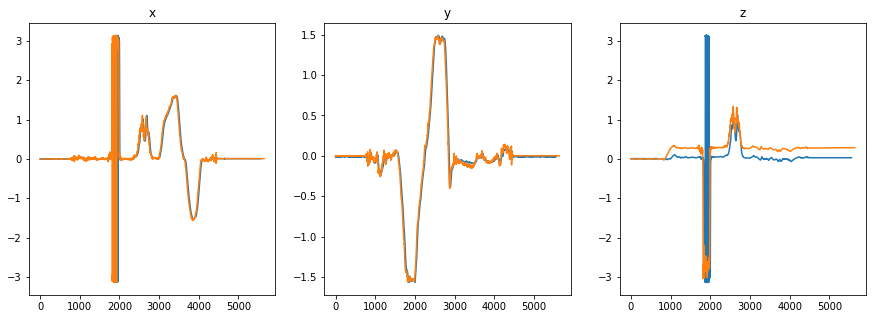

In [ ]:
Q_iters_np = jnp.array(Q_iters)
temp = jnp.zeros((3, Q_iters_np[-1, 0, :].shape[0]))
for i in range(Q_iters_np[-1, 0, :].shape[0]):
  temp = temp.at[:, i].set(jnp.array(transforms3d.euler.quat2euler(Q_iters_np[-1, :,i])))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['x', 'y', 'z']
for i in range(3):
  axes[i].set_title(titles[i])
  axes[i].plot(V[i,:])
  axes[i].plot(temp[i])
  # axes[i].plot(Q_to_V[i,:])
plt.show()

In [ ]:
A_after_grad = calculate_a(Q_iters_np[-1])
# for i, q in enumerate(Q_iters_np[-1].T):
#   A_after_grad = A_after_grad.at[:, i].set(calculate_a(q))

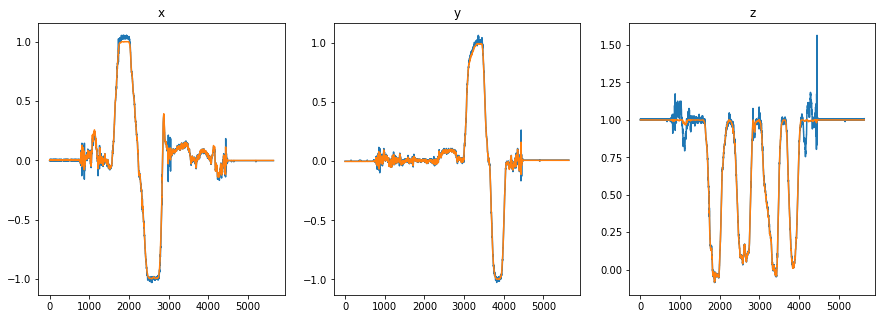

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['x', 'y', 'z']
for i in range(3):
  axes[i].set_title(titles[i])
  axes[i].plot(A_corrected[i])
  axes[i].plot(A_after_grad[i+1,:])
plt.show()

In [ ]:
pkl_file = open('Q_iterations.pkl', 'wb')
pickle.dump(Q_iters_np, pkl_file)
pkl_file.close()

In [ ]:
!cp '/content/Q_iterations.pkl' "/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR1/Q_iterations.pkl"

### Panorama

In [172]:
cam_time_map = {}
cam_map_R = []
for t in camd['ts'][0]:
  temp = np.abs(vicd['ts'][0] - t)
  index = np.argmin(temp)
  cam_time_map[t] = index
  # cam_map_R.append(vicd['rots'][:,:,index].reshape((3,3)))
# cam_map_R = np.array(cam_map_R)

Images are of size 240 x 320
H =  240, W = 320
The field of view of the camera is 60 degrees horizontally and 45 degrees vertically
Therefore, each pixel occupies 45/240 degree angle vertically and 60/320 degree angle horizontally
Each pixel can be mapped to a spherical coordinate using this

Pixel values are calculated wrt the vertical angles
Angles range from 90-30 to 90+30 vertically, and 90-22.5 to 90-22.5 horzontally

In [173]:
H, W, vert, hor = 240, 320, 45., 60.
z_angles, x_angles = np.linspace(90-(vert/2), 90+(vert/2)-1, int(H)) * np.pi/180, np.linspace(90-(hor/2), 90+(hor/2)-1, int(W))*np.pi/180

In [174]:
# Coordinates are (Z, X, Y) (phi, theta, rho) (long, lat, dist)
# spherical = np.ones((H, W, 3))
# for i, z in enumerate(z_angles):
#   spherical[i, :, 0] = x_angles
# for i, x in enumerate(x_angles):
#   spherical[:, i, 1] = z_angles

In [175]:
cartesian_temp, cartesian = np.ones((H, W, 4)), np.ones((H, W, 3))

for i in range(z_angles.shape[0]):
  cartesian_temp[i, :, 0] = np.cos(x_angles)
for i in range(x_angles.shape[0]):
  cartesian_temp[:, i, 1] = np.cos(z_angles)
for i in range(z_angles.shape[0]):
  cartesian_temp[i, :, 2] = np.sin(x_angles)
for i in range(x_angles.shape[0]):
  cartesian_temp[:, i, 3] = np.sin(z_angles)

cartesian[:,:,0] = np.multiply(cartesian_temp[:,:,3], cartesian_temp[:,:,0])
cartesian[:,:,1] = np.multiply(cartesian_temp[:,:,3], cartesian_temp[:,:,2])
cartesian[:,:,2] = cartesian_temp[:,:,1]

In [176]:
world_frame_cartesian = np.zeros((240, 320, 3, len(cam_time_map.keys())))
for i in range(camd['cam'].shape[3]):
  world_frame_cartesian[:,:,:,i] = np.dot(cartesian, vicd['rots'][:, :, cam_time_map[camd['ts'][0][i]]])

In [177]:
lambert = np.zeros((240, 320, 2, len(cam_time_map.keys())))
lambert[:,:,0,:] = np.sqrt(2/(1-world_frame_cartesian[:,:,2,:])) * world_frame_cartesian[:,:,0,:]
lambert[:,:,1,:] = np.sqrt(2/(1-world_frame_cartesian[:,:,2,:])) * world_frame_cartesian[:,:,1,:]

In [178]:
abs_lamb = 250*lambert
abs_lamb = abs_lamb.astype(np.int32)

In [179]:
abs_lamb = abs_lamb-np.min(abs_lamb)

In [180]:
image = np.zeros((1000, 1000, 3)).astype(np.int32)
for r in range(0, camd['cam'].shape[3], 1):
  for i in range(240):
    for j in range(320):
      x, y = abs_lamb[i, j, :, r]
      image[y, x, :] = camd['cam'][i, j, :, r]

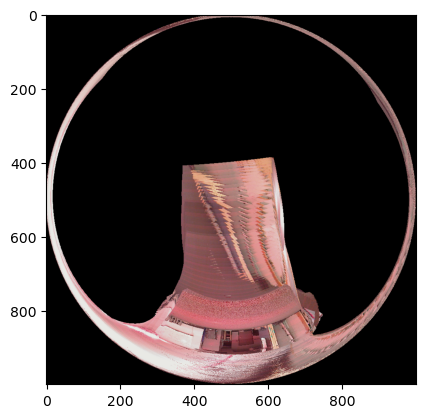

In [181]:
plt.imshow(image)

In [182]:
from PIL import Image
Image.fromarray(image.astype(np.uint8)).save('temp2.jpg')

In [ ]:
del cartesian_temp, cartesian, abs_lamb, image
# , image, lambert, abs_lamb

In [84]:
spherical_from_cartesian = np.zeros((camd['cam'].shape[0], camd['cam'].shape[1], camd['cam'].shape[2], camd['ts'].shape[1]))

spherical_from_cartesian_r = np.sqrt(np.sum(np.power(world_frame_cartesian, 2), axis=3))
spherical_from_cartesian[:,:,0,:] = spherical_from_cartesian_r #rho
spherical_from_cartesian[:,:,1,:] = np.arctan(world_frame_cartesian[:,:,:,1]/world_frame_cartesian[:,:,:,0]) #theta
spherical_from_cartesian[:,:,2,:] = np.arccos(world_frame_cartesian[:,:,:,2]/spherical_from_cartesian_r) #phi

In [85]:
del spherical_from_cartesian_r

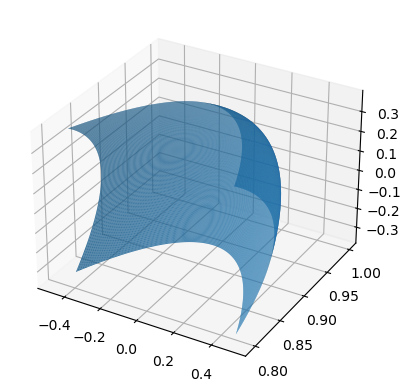

In [91]:
fig = plt.figure()
i = 10
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    world_frame_cartesian[:, :, i, 0], world_frame_cartesian[:, :, i, 1], world_frame_cartesian[:, :, i, 2], rstride=1, cstride=1)

plt.show()

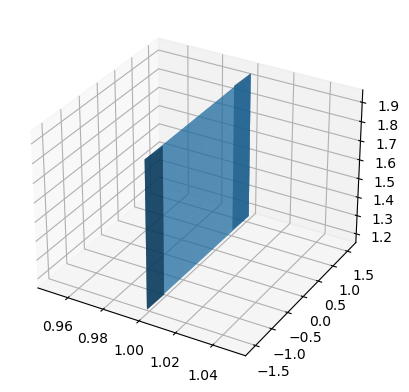

In [92]:
fig = plt.figure()
i = 100
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    spherical_from_cartesian[:, :, 0, i], spherical_from_cartesian[:, :, 1,i], spherical_from_cartesian[:, :, 2,i], rstride=1, cstride=1)

plt.show()

In [38]:
cylindrical_from_spherical = np.zeros(camd['cam'].shape)

cylindrical_from_spherical[:,:,0,:] = np.multiply(spherical_from_cartesian[:,:,0,:], np.sin(spherical_from_cartesian[:,:,2,:]))
cylindrical_from_spherical[:,:,1,:] = spherical_from_cartesian[:,:,1,:]
cylindrical_from_spherical[:,:,2,:] = np.multiply(spherical_from_cartesian[:,:,0,:], np.cos(spherical_from_cartesian[:,:,1,:]))
# cylindrical_from_spherical /= cylindrical_from_spherical[:,:,:,:]/cylindrical_from_spherical[:,:,0,:][:,:,np.newaxis,:]

In [39]:
np.min(cylindrical_from_spherical), np.max(cylindrical_from_spherical)

(-1.5707963234836575, 1.5707962885619209)

In [40]:
# world_frame_cartesian=None
del spherical_from_cartesian

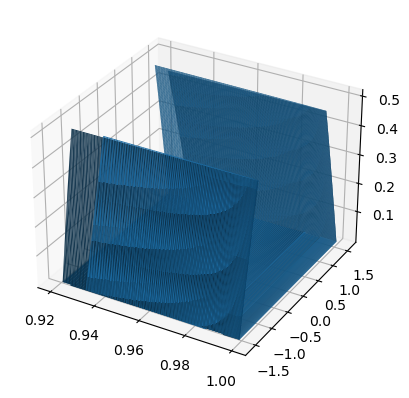

In [41]:
fig = plt.figure()
i = 100
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    cylindrical_from_spherical[:, :, 0, i], cylindrical_from_spherical[:, :, 1,i], cylindrical_from_spherical[:, :, 2,i], rstride=1, cstride=1)

plt.show()

In [ ]:
pkl_file = open('cylidrical.pkl', 'wb')
pickle.dump(cylindrical_from_spherical, pkl_file)
pkl_file.close()

with open('cylidrical.pkl', 'rb') as f:
  if sys.version_info[0] < 3:
    cylindrical_from_spherical = pickle.load(f)
  else:
    cylindrical_from_spherical = pickle.load(f, encoding='latin1')

In [ ]:
# !cp '/content/cylidrical.pkl' "/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR1/cylidrical.pkl"

In [ ]:
# !cp "/content/drive/MyDrive/Course Materials/2 Winter 23/ECE 276A Sensing & Estimation in Robotics/Projects/ECE276A_PR1/cylidrical.pkl" '/content/cylidrical.pkl'

In [115]:
out = (spherical_from_cartesian*100).astype(np.int32)

In [118]:
np.min(spherical_from_cartesian[:,:,1:,:])*100, np.max(spherical_from_cartesian[:,:,1:,:])*100,
# (np.min(spherical_from_cartesian[:,:,1:,:])*100).astype(np.int32), (np.max(spherical_from_cartesian[:,:,1:,:])*100).astype(np.int32)

(-157.07963234836575, 314.1303508630581)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


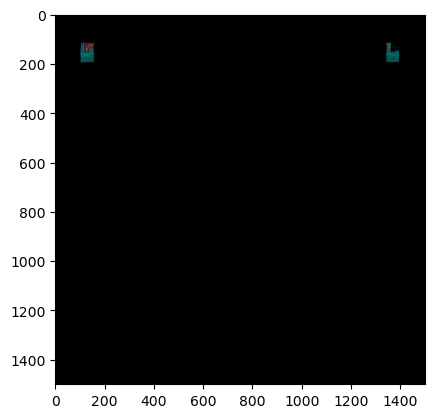

In [101]:
image = np.zeros((1500, 1500, 3)).astype(np.int8)
for r in range(100):
  for i in range(H):
    for j in range(W):
      coord = out[i, j, :, r]
      image[coord[2], coord[1], :] = camd['cam'][i, j, :, r]
plt.imshow(image)

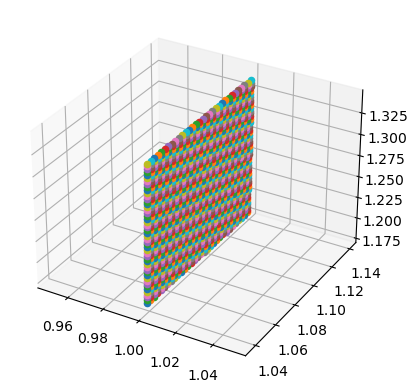

In [125]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(50):
    for j in range(32):
        x, y, z = spherical_from_cartesian[i, j, :, 80]
        ax.scatter(x, y, z)

In [119]:
del image, out, cylindrical_from_spherical

array([[[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.03476389,  1.03550068,  1.03602706, ...,  1.01700816,
           1.01700816,  1.01700816],
         [ 1.17980756,  1.18080433,  1.18121389, ...,  1.18369651,
           1.18369651,  1.18369651]],

        [[ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.03798937,  1.03872488,  1.03925074, ...,  1.02022877,
           1.02022877,  1.02022877],
         [ 1.17976661,  1.18076672,  1.18117791, ...,  1.18369779,
           1.18369779,  1.18369779]],

        [[ 1.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  1.        ],
         [ 1.04121491,  1.04194913,  1.04247447, ...,  1.02344939,
           1.02344939,  1.02344939],
         [ 1.17972564,  1.18072907,  1.1811419 , ...,  1.18369902,
           1.18369902,  1.18369902]],

        ...,

        [[ 1.        ,  1.        ,  1.     